In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os, sys


# Set seed
torch.manual_seed(0)
from torch.optim.lr_scheduler import StepLR

sys.path.append("..")

from src.utils import uniform_weights
from src.ground_cost import l2_cost2, l2_cost, batch_l2_cost2
from src.discrete_entropic_reg import (soft_c_transform, 
                                       soft_exponential_cost, 
                                       normalised_soft_exponential_cost, 
                                       stochastic_dual_approx)

## Grad check

In [2]:
num_atoms = 2

x = torch.tensor([0.,1.])
ys = torch.tensor([[2.,0.], [1.,1.]], requires_grad = True)
g = torch.tensor([1.5,1.5], dtype=torch.double, requires_grad = True)
b = uniform_weights(num_atoms, dtype=torch.double)
epsilon = torch.tensor(0.01)

n_iters = 10000
n_sub_iters = 10
batch_size = 1 

In [3]:
#manual
b - normalised_soft_exponential_cost(x, ys, g, cost_func = l2_cost2, epsilon = epsilon)

tensor([ 0.5000, -0.5000], dtype=torch.float64, grad_fn=<SubBackward0>)

In [4]:
# computed
approx = stochastic_dual_approx(x, ys, b, g, cost_func = l2_cost2, epsilon = epsilon)
approx.backward()
g.grad

tensor([ 0.5000, -0.5000], dtype=torch.float64)

## INSTANTIATE OPTIMIZER CLASS

## INSTANTIATE STEP LEARNING SCHEDULER CLASS

##  RE-INIT and TRAIN MODEL

In [234]:
def verbose_print(obj, verbose):
    if verbose:
        print(obj)

tensor([-2.4423e-06, -5.8833e-05,  9.7898e-05, -2.5753e-05, -1.0783e-04,
        -1.9749e-05, -7.3759e-05, -4.6884e-05, -2.1009e-04, -3.7542e-05,
        -7.4567e-05,  1.3085e-04,  2.1436e-04, -1.5705e-04,  2.4546e-04,
        -1.7496e-05,  5.6960e-05,  1.1389e-04, -5.8277e-05,  3.0856e-05],
       dtype=torch.float64, grad_fn=<CloneBackward>)

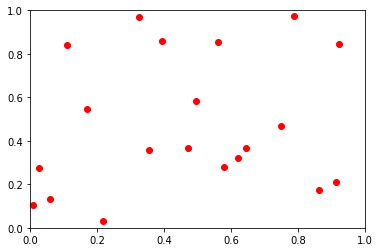

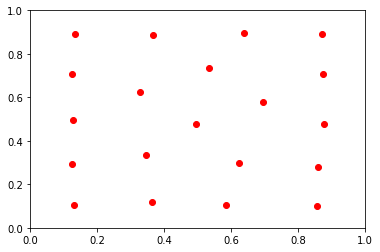

In [270]:
n_iters = 10000
n_sub_iters_map = 10
n_sub_iters_atoms = 10
num_atoms = 20
dim = 2
batch_size = 1
verbose = True

# init vectors
ys = torch.tensor(5.*(np.random.random(size=(num_atoms,dim))-0.5), requires_grad = True)
ys = torch.tensor((np.random.random(size=(num_atoms,dim))), requires_grad = True)
g = torch.tensor(np.zeros(num_atoms), requires_grad = True)
b = uniform_weights(num_atoms)
epsilon = torch.tensor(0.01)

# optimizers
learning_rate = 0.1
optimizer_atoms = torch.optim.ASGD([ys], lr=learning_rate)
optimizer_map = torch.optim.ASGD([g], lr=learning_rate)

scheduler_atoms = StepLR(optimizer_atoms, step_size=1, gamma=0.9)
scheduler_map = StepLR(optimizer_map, step_size=1, gamma=0.9)

# sample
alpha_dist = dist.Uniform(torch.tensor([0.,0.]), torch.tensor([1.,1.]))

y_plot = ys.detach().numpy()
plt.plot(y_plot[:,0], y_plot[:,1], "ro")
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

### Min Max Optimization
for i in range(n_iters):
    for _ in range(n_sub_iters_map):
        # sample x
        xs = alpha_dist.sample(sample_shape=(batch_size,))

        # Clear gradients w.r.t. parameters
        optimizer_map.zero_grad()
        
        # Get dual objective to maximise
        dual_objective = stochastic_dual_approx(xs, ys, b, g, cost_func = batch_l2_cost2, epsilon = epsilon)
        map_loss = -dual_objective
        
        # Getting gradients w.r.t. parameters
        map_loss.backward()

        # Updating parameters
        optimizer_map.step()
        
    for _ in range(n_sub_iters_atoms):
        # sample x
        xs = alpha_dist.sample(sample_shape=(batch_size,))

        # Clear gradients w.r.t. parameters
        optimizer_atoms.zero_grad()
        
        # Get loss objective to minimise
        atoms_loss = stochastic_dual_approx(xs, ys, b, g, cost_func = batch_l2_cost2, epsilon = epsilon)
        
        # Getting gradients w.r.t. parameters
        atoms_loss.backward()

        # Updating parameters
        optimizer_atoms.step()
    
    # Updating parameters
    if i % 100 == 0:
        # Decay Learning Rate
        scheduler_atoms.step()
        scheduler_map.step()
    

y_plot = ys.detach().numpy()
plt.plot(y_plot[:,0], y_plot[:,1], "ro")
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [ ]:
n_iters = 10000
n_sub_iters_map = 10
n_sub_iters_atoms = 10
lr_steps = 100

num_atoms = 100
dim = 2
batch_size = 1
verbose = True

# init vectors
ys = torch.tensor(np.random.normal(size=(num_atoms,dim)), requires_grad = True)
g = torch.tensor(np.zeros(num_atoms), requires_grad = True)
b = uniform_weights(num_atoms)
epsilon = torch.tensor(0.01)

# optimizers
learning_rate = 0.1
optimizer_atoms = torch.optim.ASGD([ys], lr=learning_rate)
optimizer_map = torch.optim.ASGD([g], lr=learning_rate)

scheduler_atoms = StepLR(optimizer_atoms, step_size=1, gamma=0.9)
scheduler_map = StepLR(optimizer_map, step_size=1, gamma=0.9)

# sample
alpha_dist = dist.MultivariateNormal(torch.tensor([0.,0.]), torch.tensor([[1.,0.],[0.,1.]]))

y_plot = ys.detach().numpy()
plt.plot(y_plot[:,0], y_plot[:,1], "ro")
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

### Min Max Optimization
for i in range(n_iters):
    for _ in range(n_sub_iters_map):
        # sample x
        xs = alpha_dist.sample(sample_shape=(batch_size,))

        # Clear gradients w.r.t. parameters
        optimizer_map.zero_grad()
        
        # Get dual objective to maximise
        dual_objective = stochastic_dual_approx(xs, ys, b, g, cost_func = batch_l2_cost2, epsilon = epsilon)
        map_loss = -dual_objective
        
        # Getting gradients w.r.t. parameters
        map_loss.backward()

        # Updating parameters
        optimizer_map.step()
        
    for _ in range(n_sub_iters_atoms):
        # sample x
        xs = alpha_dist.sample(sample_shape=(batch_size,))

        # Clear gradients w.r.t. parameters
        optimizer_atoms.zero_grad()
        
        # Get loss objective to minimise
        atoms_loss = stochastic_dual_approx(xs, ys, b, g, cost_func = batch_l2_cost2, epsilon = epsilon)
        
        # Getting gradients w.r.t. parameters
        atoms_loss.backward()

        # Updating parameters
        optimizer_atoms.step()
    
    # Updating parameters
    if i % lr_steps == 0:
        # Decay Learning Rate
        scheduler_atoms.step()
        scheduler_map.step()
        

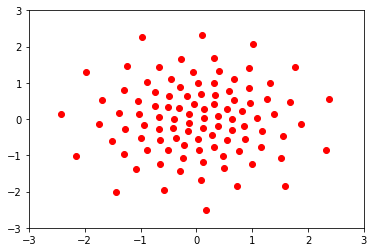

In [272]:
y_plot = ys.detach().numpy()
plt.plot(y_plot[:,0], y_plot[:,1], "ro")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

In [505]:
samples = np.random.normal(size = 500)

In [506]:
np.max(samples), np.min(samples)

(2.7239377096349453, -3.04645940934688)

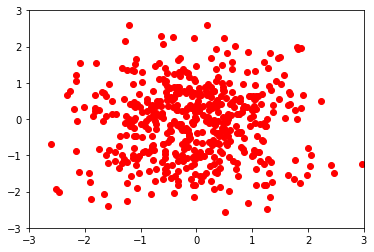

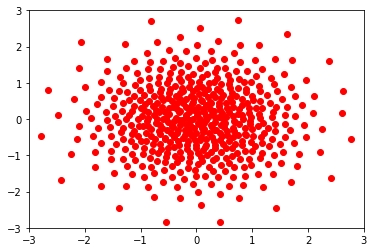

In [269]:
n_iters = 10000
n_sub_iters_map = 10
n_sub_iters_atoms = 10
lr_steps = 500

num_atoms = 500
dim = 2
batch_size = 1
verbose = True

# init vectors
ys = torch.tensor(np.random.normal(size=(num_atoms,dim)), requires_grad = True)
g = torch.tensor(np.zeros(num_atoms), requires_grad = True)
b = uniform_weights(num_atoms)
epsilon = torch.tensor(0.01)

# optimizers
learning_rate = 0.1
optimizer_atoms = torch.optim.ASGD([ys], lr=learning_rate)
optimizer_map = torch.optim.ASGD([g], lr=learning_rate)

scheduler_atoms = StepLR(optimizer_atoms, step_size=1, gamma=0.9)
scheduler_map = StepLR(optimizer_map, step_size=1, gamma=0.9)

# sample
alpha_dist = dist.MultivariateNormal(torch.tensor([0.,0.]), torch.tensor([[1.,0.],[0.,1.]]))

y_plot = ys.detach().numpy()
plt.plot(y_plot[:,0], y_plot[:,1], "ro")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

### Min Max Optimization
for i in range(n_iters):
    for _ in range(n_sub_iters_map):
        # sample x
        xs = alpha_dist.sample(sample_shape=(batch_size,))

        # Clear gradients w.r.t. parameters
        optimizer_map.zero_grad()
        
        # Get dual objective to maximise
        dual_objective = stochastic_dual_approx(xs, ys, b, g, cost_func = batch_l2_cost2, epsilon = epsilon)
        map_loss = -dual_objective
        
        # Getting gradients w.r.t. parameters
        map_loss.backward()

        # Updating parameters
        optimizer_map.step()
        
    for _ in range(n_sub_iters_atoms):
        # sample x
        xs = alpha_dist.sample(sample_shape=(batch_size,))

        # Clear gradients w.r.t. parameters
        optimizer_atoms.zero_grad()
        
        # Get loss objective to minimise
        atoms_loss = stochastic_dual_approx(xs, ys, b, g, cost_func = batch_l2_cost2, epsilon = epsilon)
        
        # Getting gradients w.r.t. parameters
        atoms_loss.backward()

        # Updating parameters
        optimizer_atoms.step()
    
    # Updating parameters
    if i % lr_steps == 0:
        # Decay Learning Rate
        scheduler_atoms.step()
        scheduler_map.step()
        
y_plot = ys.detach().numpy()
plt.plot(y_plot[:,0], y_plot[:,1], "ro")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

In [375]:
class GausMix(object):
    def __init__(self, mu1 = [-3.,-3.],mu2= [3.,3.], p = 0.5):
        self.mu1 = mu1
        self.mu2 = mu2
        self.p = p
        
        self.dist1 = dist.MultivariateNormal(torch.tensor(self.mu1), torch.tensor([[1.,0.],[0.,1.]]))
        self.dist2 = dist.MultivariateNormal(torch.tensor(self.mu2), torch.tensor([[1.,0.],[0.,1.]]))
        self.uniform_dist = dist.Uniform(torch.tensor(0.), torch.tensor(1.))
        
    
    def sample_one(self):
        if self.uniform_dist.sample() < self.p:
            return self.dist1.sample()
        else:
            return self.dist2.sample()
        
    def sample(self, sample_shape = (1,)):
        num = sample_shape[0]
        output = []
        for _ in range(num):
            output.append(self.sample_one())
        return torch.stack(output)
        
        

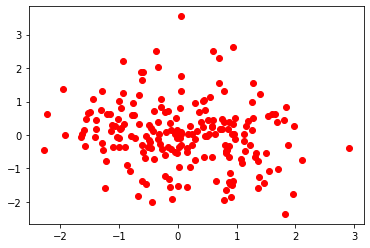

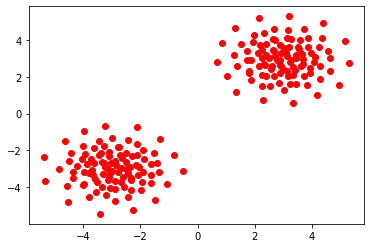

In [469]:
n_iters = 10000
n_sub_iters_map = 10
n_sub_iters_atoms = 10
lr_steps = 500

num_atoms = 200
dim = 2
batch_size = 1
verbose = True

# init vectors
init_ys = np.random.normal(size=(num_atoms,dim))
ys = torch.tensor(init_ys, requires_grad = True)
g = torch.tensor(np.zeros(num_atoms), requires_grad = True)
b = uniform_weights(num_atoms)
epsilon = torch.tensor(0.1)

# optimizers
learning_rate = 0.1
optimizer_atoms = torch.optim.ASGD([ys], lr=learning_rate)
optimizer_map = torch.optim.ASGD([g], lr=learning_rate)

scheduler_atoms = StepLR(optimizer_atoms, step_size=1, gamma=0.9)
scheduler_map = StepLR(optimizer_map, step_size=1, gamma=0.9)

# sample
alpha_dist = GausMix()

y_plot = ys.detach().numpy()
plt.plot(y_plot[:,0], y_plot[:,1], "ro")
plt.show()

samples = []
### Min Max Optimization
for i in range(n_iters):
    for _ in range(n_sub_iters_map):
        # sample x
        xs = alpha_dist.sample(sample_shape=(batch_size,))
        samples.append(xs)
        
        # Clear gradients w.r.t. parameters
        optimizer_map.zero_grad()
        
        # Get dual objective to maximise
        dual_objective = stochastic_dual_approx(xs, ys, b, g, cost_func = batch_l2_cost2, epsilon = epsilon)
        map_loss = -dual_objective
        
        # Getting gradients w.r.t. parameters
        map_loss.backward()

        # Updating parameters
        optimizer_map.step()

        
    for _ in range(n_sub_iters_atoms):
        # sample x
        xs = alpha_dist.sample(sample_shape=(batch_size,))
        samples.append(xs)
        
        # Clear gradients w.r.t. parameters
        optimizer_atoms.zero_grad()
        
        # Get loss objective to minimise
        atoms_loss = stochastic_dual_approx(xs, ys, b, g, cost_func = batch_l2_cost2, epsilon = epsilon)
        
        # Getting gradients w.r.t. parameters
        atoms_loss.backward()

        # Updating parameters
        optimizer_atoms.step()
    
    # Updating parameters
    if i % lr_steps == 0:
        # Decay Learning Rate
        scheduler_atoms.step()
        scheduler_map.step()
        
y_plot = ys.detach().numpy()
plt.plot(y_plot[:,0], y_plot[:,1], "ro")
plt.show()

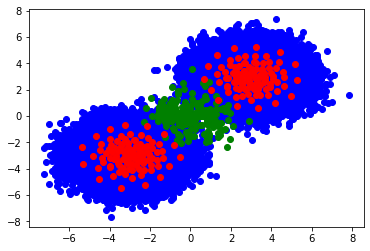

In [473]:


plot_samples = torch.stack(samples, axis = 0).squeeze()
plot_samples = plot_samples.numpy()
plt.plot(plot_samples[:,0], plot_samples[:,1], "bo")

y_plot = ys.detach().numpy()
plt.plot(init_ys[:,0], init_ys[:,1], 'go')
plt.plot(y_plot[:,0], y_plot[:,1], "ro")

plt.show()

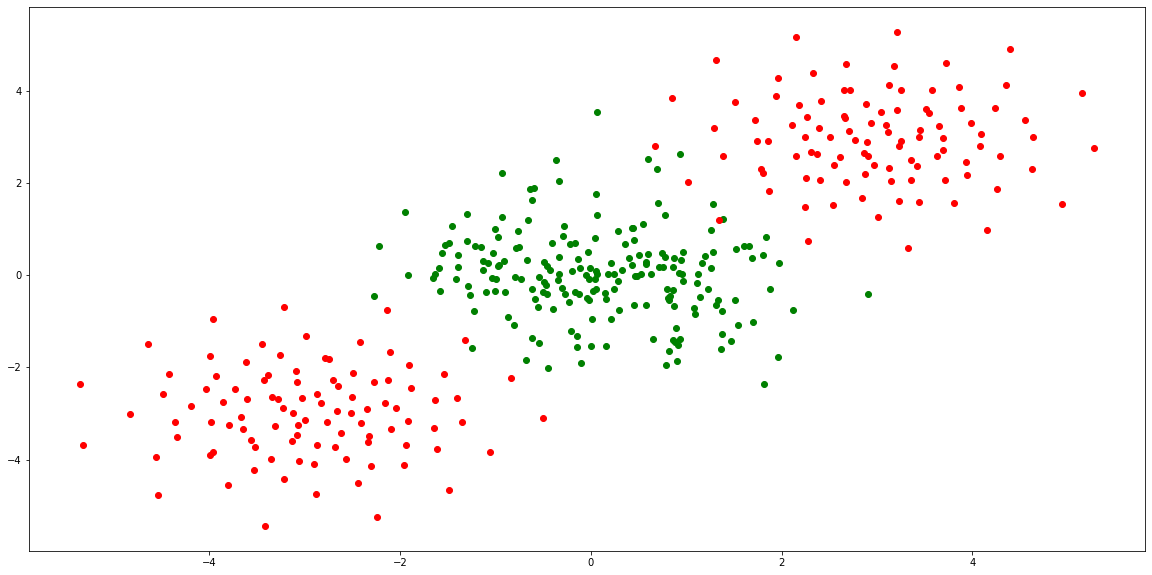

In [493]:
plt.figure(figsize=(20,10))
plt.plot(init_ys[:,0], init_ys[:,1], 'go')
plt.plot(y_plot[:,0], y_plot[:,1], "ro")
plt.show()

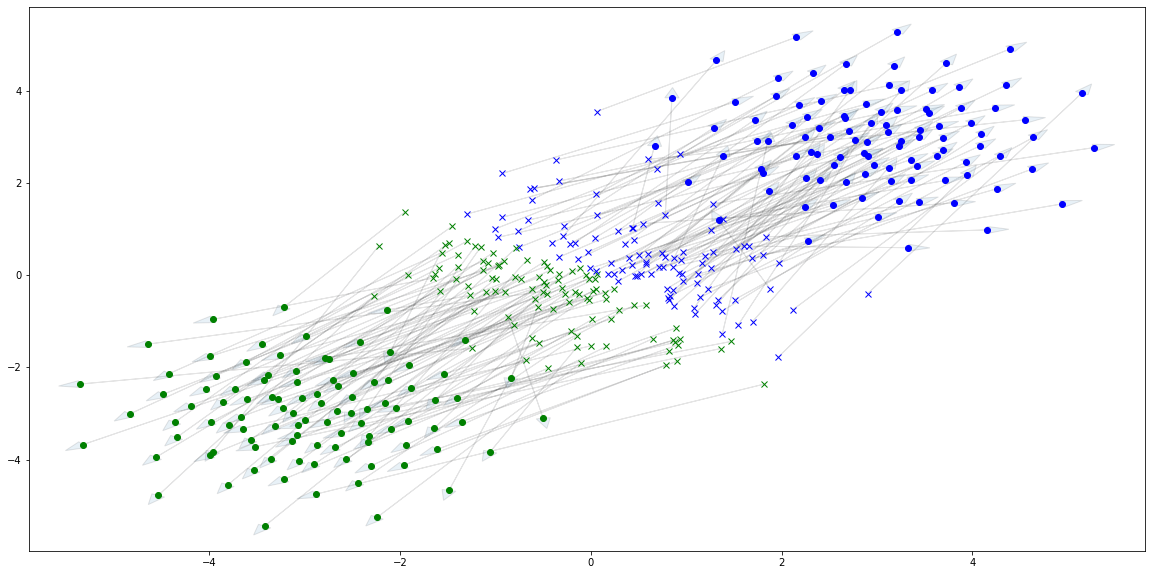

In [503]:
plt.figure(figsize=(20,10))
for i in range(np.shape(init_ys)[0]):
    dx, dy = y_plot[i] - init_ys[i] 
    if np.sum((y_plot[i,:]- np.array([-1,-1]))**2) > np.sum((y_plot[i,:]- np.array([1,1]))**2):
        col = "b"
    else:
        col = "g"
    plt.arrow(init_ys[i,0], init_ys[i,1], dx, dy, head_width=0.15, alpha = 0.1)
    plt.plot(init_ys[i,0], init_ys[i,1], col+"x")
    plt.plot(y_plot[i,0], y_plot[i,1], col+"o")
plt.show()

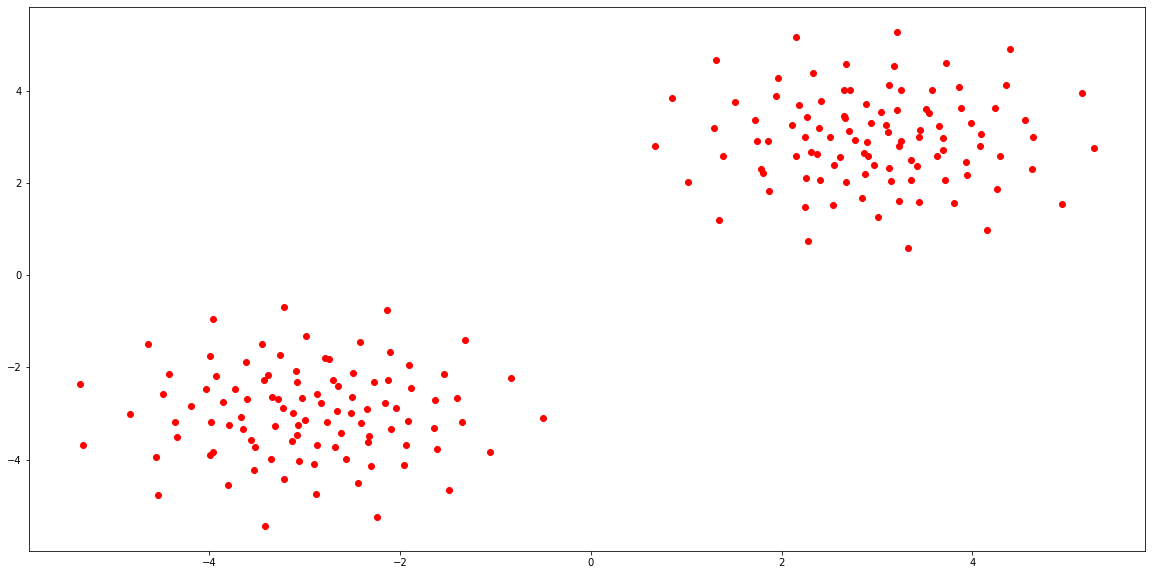

In [494]:
plt.figure(figsize=(20,10))
plt.plot(y_plot[:,0], y_plot[:,1], "ro")
plt.show()

array([[ 2.7623897,  3.2526405],
       [-3.541343 , -2.969171 ],
       [-4.3320265, -3.8999166],
       ...,
       [-2.209972 , -2.539225 ],
       [-2.8401268, -3.581333 ],
       [-1.9715478, -0.7207563]], dtype=float32)

array([[2.7623897, 3.2526405]], dtype=float32)

In [ ]:
plots_xs

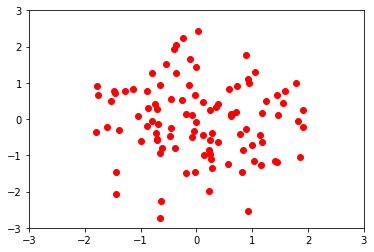

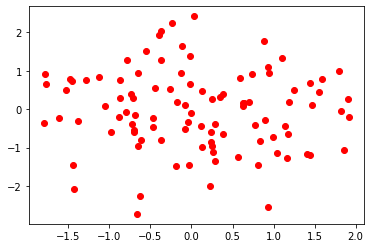

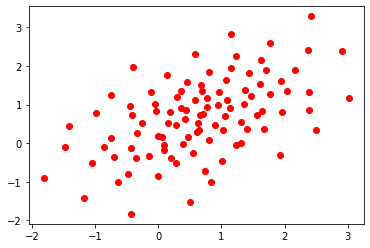

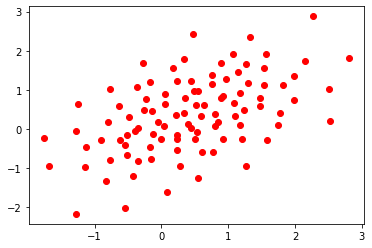

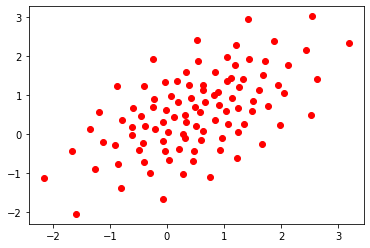

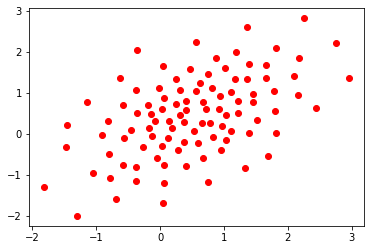

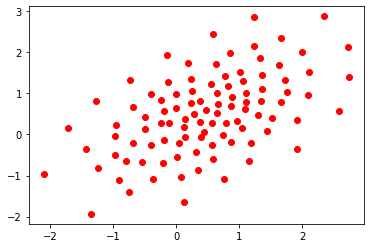

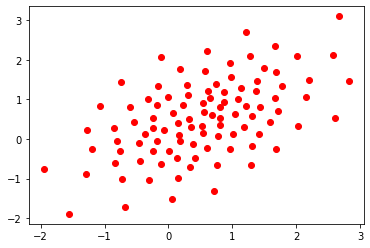

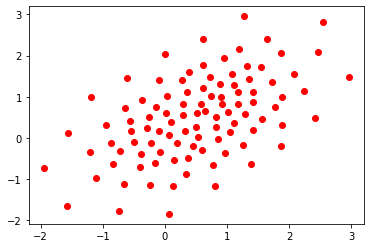

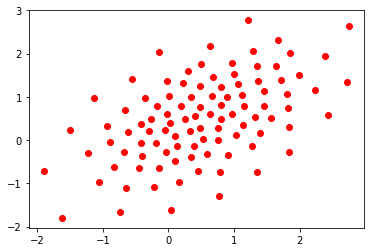

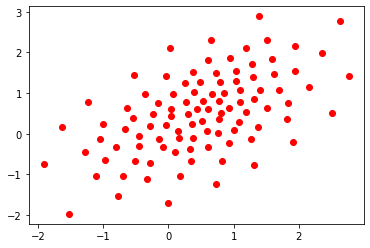

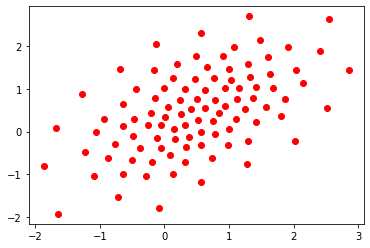

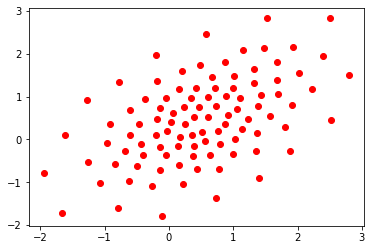

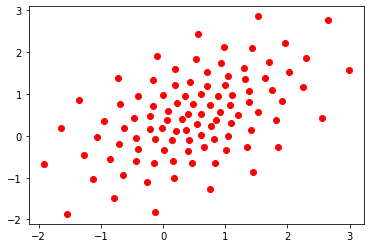

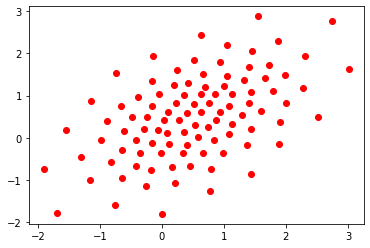

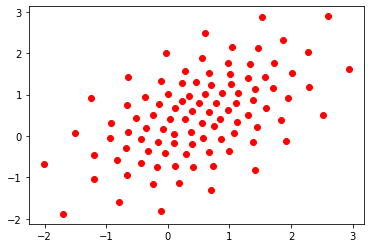

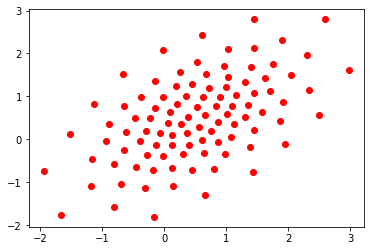

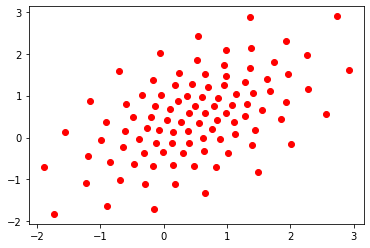

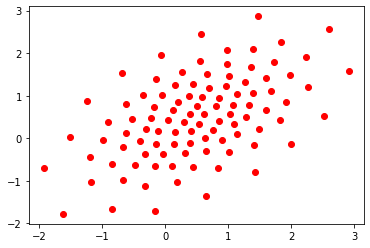

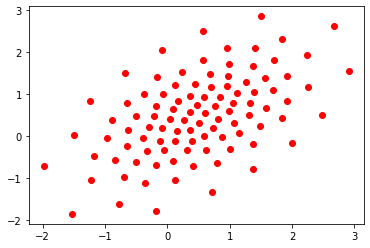

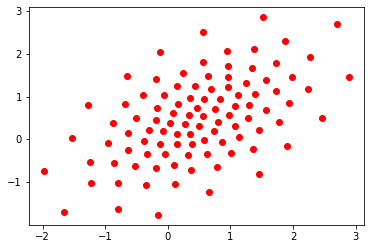

In [287]:
n_iters = 10000
n_sub_iters_map = 10
n_sub_iters_atoms = 10
lr_steps = 500

num_atoms = 100
dim = 2
batch_size = 1
verbose = True

# init vectors
ys = torch.tensor(np.random.normal(size=(num_atoms,dim)), requires_grad = True)
g = torch.tensor(np.zeros(num_atoms), requires_grad = True)
b = uniform_weights(num_atoms)
epsilon = torch.tensor(0.01)

# optimizers
learning_rate = 0.1
optimizer_atoms = torch.optim.ASGD([ys], lr=learning_rate)
optimizer_map = torch.optim.ASGD([g], lr=learning_rate)

scheduler_atoms = StepLR(optimizer_atoms, step_size=1, gamma=0.9)
scheduler_map = StepLR(optimizer_map, step_size=1, gamma=0.9)

# sample
alpha_dist = dist.MultivariateNormal(torch.tensor([0.5,0.5]), torch.tensor([[1.,0.5],[0.5,1.]]))

y_plot = ys.detach().numpy()
plt.plot(y_plot[:,0], y_plot[:,1], "ro")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

### Min Max Optimization
for i in range(n_iters):
    for _ in range(n_sub_iters_map):
        # sample x
        xs = alpha_dist.sample(sample_shape=(batch_size,))

        # Clear gradients w.r.t. parameters
        optimizer_map.zero_grad()
        
        # Get dual objective to maximise
        dual_objective = stochastic_dual_approx(xs, ys, b, g, cost_func = batch_l2_cost2, epsilon = epsilon)
        map_loss = -dual_objective
        
        # Getting gradients w.r.t. parameters
        map_loss.backward()

        # Updating parameters
        optimizer_map.step()
        
    for _ in range(n_sub_iters_atoms):
        # sample x
        xs = alpha_dist.sample(sample_shape=(batch_size,))

        # Clear gradients w.r.t. parameters
        optimizer_atoms.zero_grad()
        
        # Get loss objective to minimise
        atoms_loss = stochastic_dual_approx(xs, ys, b, g, cost_func = batch_l2_cost2, epsilon = epsilon)
        
        # Getting gradients w.r.t. parameters
        atoms_loss.backward()

        # Updating parameters
        optimizer_atoms.step()
    
    # Updating parameters
    if i % lr_steps == 0:
        # Decay Learning Rate
        scheduler_atoms.step()
        scheduler_map.step()
        
        y_plot = ys.detach().numpy()
        plt.plot(y_plot[:,0], y_plot[:,1], "ro")
        plt.show()

In [282]:
np.mean(y_plot, axis = 0)

array([0.420685  , 0.42285719])

In [285]:
np.cov(y_plot[:,0], y_plot[:,1])

array([[0.95108634, 0.48036728],
       [0.48036728, 0.94959777]])